In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [2]:
# Load the GeoJSON file
geojson_file = "gronigen/building_footprint.geojson"
gdf = gpd.read_file(geojson_file)

# Convert CRS to meters for accurate calculations
gdf = gdf.to_crs(epsg=3857)


In [3]:
print(gdf.head())


  abandoned:amenity access addr:city addr:country addr:housename  \
0              None   None      None         None           None   
1              None   None      None         None           None   
2              None   None      None         None           None   
3              None   None      None         None           None   
4              None   None      None         None           None   

  addr:housenumber addr:postcode addr:street aeroway alt_name  ... voltage  \
0             None          None        None    None     None  ...    None   
1             None          None        None    None     None  ...    None   
2             None          None        None    None     None  ...    None   
3             None          None        None    None     None  ...    None   
4             None          None        None    None     None  ...    None   

  waterway website wheelchair wikidata wikimedia_commons wikipedia  \
0     None    None       None     None              

In [4]:
gdf.columns

Index(['abandoned:amenity', 'access', 'addr:city', 'addr:country',
       'addr:housename', 'addr:housenumber', 'addr:postcode', 'addr:street',
       'aeroway', 'alt_name',
       ...
       'voltage', 'waterway', 'website', 'wheelchair', 'wikidata',
       'wikimedia_commons', 'wikipedia', 'winkelnummer', 'zoo', 'geometry'],
      dtype='object', length=224)

In [5]:
# Compute area and perimeter
gdf["area_sqm"] = gdf.geometry.area
gdf["perimeter_m"] = gdf.geometry.length

# Define estimated population based on building type
population_factor = {
    "residential": 1 / 30,  # 1 person per 30 sqm
    "commercial": 1 / 20,  # 1 person per 20 sqm
    "office": 1 / 10  # 1 person per 10 sqm
}

# Assign population estimate
gdf["building_type"] = gdf.get("building_type", "unknown")  # Default to unknown if not present
gdf["estimated_population"] = gdf.apply(
    lambda row: int(row["area_sqm"] * population_factor.get(row["building_type"], 1 / 40)), axis=1
)

# Define order factor per building type
order_factor = {"residential": 50, "commercial": 100, "office": 150}

# Calculate estimated orders using Poisson distribution
gdf["estimated_orders"] = gdf.apply(
    lambda row: np.random.poisson(order_factor.get(row["building_type"], 50) * (row["estimated_population"] / 500)),
    axis=1
)

# Convert back to geographic CRS for visualization
gdf = gdf.to_crs(epsg=4326)

In [6]:

# from IPython.display import display

# # ----------------------------------
# # 1️⃣ Folium Map of All Buildings
# # ----------------------------------
# m = folium.Map(location=[53.2194, 6.5665], zoom_start=13)  # Groningen coordinates

# for _, row in gdf.iterrows():
#     folium.Marker(
#         location=[row.geometry.centroid.y, row.geometry.centroid.x],
#         popup=f"Type: {row['building_type']}, Area: {row['area_sqm']:.1f} sqm",
#         icon=folium.Icon(color="blue", icon="home" if row["building_type"] == "residential" else "briefcase")
#     ).add_to(m)

 
# display(m)


#   # Show Folium map in Jupyter Notebook

# ----------------------------------
# 1️⃣ Folium Heatmap of Orders
# ----------------------------------


m = folium.Map(location=[53.2194, 6.5665], zoom_start=13)  # Groningen coordinates
heat_data = gdf[["geometry", "estimated_orders"]].dropna()
heat_data["latitude"] = heat_data.geometry.centroid.y
heat_data["longitude"] = heat_data.geometry.centroid.x

heatmap_data = list(zip(heat_data["latitude"], heat_data["longitude"], heat_data["estimated_orders"]))
HeatMap(heatmap_data, radius=15).add_to(m)

# Save the map
display(m)



/tmp/ipykernel_9088/1584122264.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  heat_data["latitude"] = heat_data.geometry.centroid.y
/tmp/ipykernel_9088/1584122264.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  heat_data["longitude"] = heat_data.geometry.centroid.x


In [7]:
# # ----------------------------------
# # 2️⃣ Heatmap of Orders
# # ----------------------------------
# heat_data = gdf[["geometry", "estimated_orders"]].dropna()
# heat_data["latitude"] = heat_data.geometry.centroid.y
# heat_data["longitude"] = heat_data.geometry.centroid.x

# heatmap_data = list(zip(heat_data["latitude"], heat_data["longitude"], heat_data["estimated_orders"]))
# orders_map = folium.Map(location=[53.2194, 6.5665], zoom_start=13)
# HeatMap(heatmap_data, radius=15).add_to(orders_map)
# orders_map.save("orders_heatmap.html")
# display(orders_map.save)


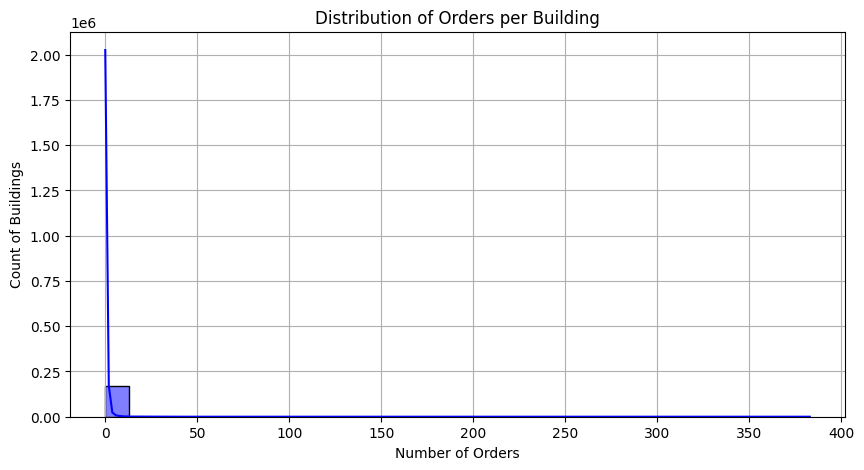

In [8]:
import matplotlib.pyplot as plt
# ----------------------------------
# 2️⃣ Histogram of Order Distribution
# ----------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(gdf["estimated_orders"], bins=30, kde=True, color="blue")
plt.xlabel("Number of Orders")
plt.ylabel("Count of Buildings")
plt.title("Distribution of Orders per Building")
plt.grid()
plt.show()


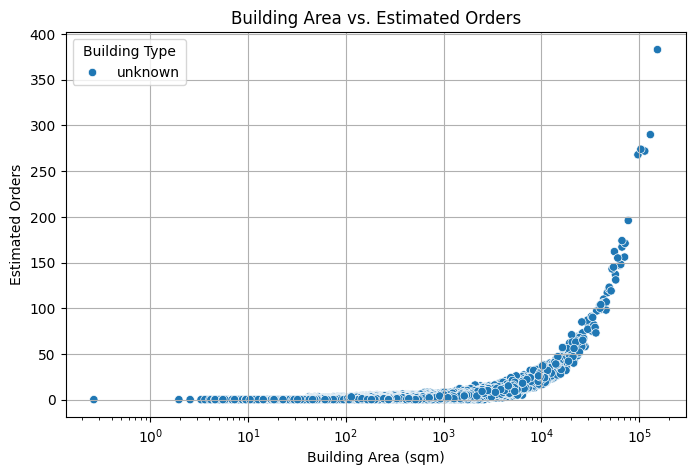

In [9]:

# ----------------------------------
# 3️⃣ Scatter Plot: Area vs. Orders
# ----------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(x=gdf["area_sqm"], y=gdf["estimated_orders"], hue=gdf["building_type"])
plt.xscale("log")  # Log scale to handle large variation
plt.xlabel("Building Area (sqm)")
plt.ylabel("Estimated Orders")
plt.title("Building Area vs. Estimated Orders")
plt.legend(title="Building Type")
plt.grid()
plt.show()
